# Исследование с учетом разницы между чистым и адверсариальным примерами

# Определение функций

## Импорты и вспомогательные функции для отрисовки

### Что делаем:

Готовим инструменты для (1) локализации патча по разнице изображений и (2) сопоставления детекций.

### Зачем:

Для «гетерогенности успеха» критично локализовать вмешательство (патч) и сопоставлять объекты между clean и patched.

IoU/matching нужен, чтобы понять: «тот же объект» пропал или просто сдвинулся.

### Откуда идея в литературе:

Thys 2019 (зависимость эффективности от положения патча), Saha 2020 (влияние патча даже при малом перекрытии), бенчмарки/анализы патчей (пространственные эффекты).

In [1]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Tuple

import math
import numpy as np
import torch
from PIL import Image

import matplotlib.pyplot as plt


# -------------------------
# Image conversions
# -------------------------

def pil_to_np_bgr(pil: Image.Image) -> np.ndarray:
    """PIL RGB -> np.uint8 BGR (H,W,3) for ultralytics predictor preprocess."""
    if pil.mode != "RGB":
        pil = pil.convert("RGB")
    rgb = np.asarray(pil)  # uint8 RGB
    bgr = rgb[..., ::-1].copy()
    return bgr


def pil_to_torch_rgb01(pil: Image.Image) -> torch.Tensor:
    """PIL -> torch float32 RGB in [0,1], shape [3,H,W] (CPU)."""
    if pil.mode != "RGB":
        pil = pil.convert("RGB")
    arr = np.asarray(pil).astype(np.float32) / 255.0
    t = torch.from_numpy(arr).permute(2, 0, 1).contiguous()
    return t


# -------------------------
# Patch application
# -------------------------

def apply_patch_to_image(
    base_pil: Image.Image,
    patch_pil: Image.Image,
    position_xy: Tuple[int, int] = (0, 0),
) -> Tuple[Image.Image, Optional[torch.Tensor], int]:
    """Paste patch onto base image at (x,y). Returns patched PIL, bbox_xyxy, area_px."""
    if base_pil.mode != "RGB":
        base_pil = base_pil.convert("RGB")
    if patch_pil.mode != "RGB":
        patch_pil = patch_pil.convert("RGB")
    base_w, base_h = base_pil.size
    patch_w, patch_h = patch_pil.size
    x, y = position_xy
    x1 = max(0, int(x))
    y1 = max(0, int(y))
    x2 = min(base_w, int(x) + patch_w)
    y2 = min(base_h, int(y) + patch_h)
    if x2 <= x1 or y2 <= y1:
        return base_pil.copy(), None, 0
    # Crop patch if it spills outside the base image.
    px1 = x1 - int(x)
    py1 = y1 - int(y)
    px2 = px1 + (x2 - x1)
    py2 = py1 + (y2 - y1)
    patch_crop = patch_pil.crop((px1, py1, px2, py2))
    out = base_pil.copy()
    out.paste(patch_crop, (x1, y1))
    bbox = torch.tensor([float(x1), float(y1), float(x2), float(y2)], dtype=torch.float32)
    area = int((x2 - x1) * (y2 - y1))
    return out, bbox, area


def show_patch_bbox(clean_rgb01: torch.Tensor, patched_rgb01: torch.Tensor, patch_bbox: Optional[torch.Tensor]) -> None:
    def imshow_rgb(t: torch.Tensor, ax, title: str):
        ax.imshow(t.detach().cpu().permute(1, 2, 0).numpy().clip(0, 1))
        ax.set_title(title)
        ax.axis("off")

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    imshow_rgb(clean_rgb01, axs[0], "Clean")
    imshow_rgb(patched_rgb01, axs[1], "Patched")

    if patch_bbox is not None:
        x1, y1, x2, y2 = patch_bbox.tolist()
        for ax in axs:
            ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, linewidth=2))
    plt.tight_layout()
    plt.show()

# -------------------------
# Box utilities
# -------------------------

def box_iou_xyxy(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    """IoU between sets of boxes in xyxy format. a[N,4], b[M,4] -> [N,M]."""
    if a.numel() == 0 or b.numel() == 0:
        return torch.zeros((a.shape[0], b.shape[0]), device=a.device, dtype=a.dtype)

    tl = torch.maximum(a[:, None, :2], b[None, :, :2])
    br = torch.minimum(a[:, None, 2:], b[None, :, 2:])
    wh = (br - tl).clamp(min=0)
    inter = wh[..., 0] * wh[..., 1]

    area_a = (a[:, 2] - a[:, 0]).clamp(min=0) * (a[:, 3] - a[:, 1]).clamp(min=0)
    area_b = (b[:, 2] - b[:, 0]).clamp(min=0) * (b[:, 3] - b[:, 1]).clamp(min=0)

    union = area_a[:, None] + area_b[None, :] - inter
    return inter / union.clamp(min=1e-9)


def greedy_match_by_iou(boxes_a: torch.Tensor, boxes_b: torch.Tensor, iou_thr: float = 0.5) -> List[Tuple[int, int, float]]:
    """Greedy IoU matching: returns list of (i_in_a, j_in_b, iou)."""
    iou = box_iou_xyxy(boxes_a, boxes_b)
    pairs: List[Tuple[int, int, float]] = []
    if iou.numel() == 0:
        return pairs

    used_a, used_b = set(), set()
    flat = []
    for i in range(iou.shape[0]):
        for j in range(iou.shape[1]):
            flat.append((i, j, float(iou[i, j].item())))
    flat.sort(key=lambda x: x[2], reverse=True)

    for i, j, v in flat:
        if v < iou_thr:
            break
        if i in used_a or j in used_b:
            continue
        used_a.add(i)
        used_b.add(j)
        pairs.append((i, j, v))
    return pairs


# -------------------------
# Patch localization by diff
# -------------------------

def estimate_patch_region_from_diff(
    clean_rgb01: torch.Tensor,
    patched_rgb01: torch.Tensor,
    diff_thr: float = 0.08,
    min_pixels: int = 50,
) -> Dict[str, Any]:
    """
    Estimate patch region via abs-diff thresholding.
    Returns:
      diff_map: [H,W] float
      mask: [H,W] bool
      bbox_xyxy: torch.Tensor[4] or None
      area_px: int
    """
    assert clean_rgb01.shape == patched_rgb01.shape
    diff = (patched_rgb01 - clean_rgb01).abs().mean(dim=0)  # [H,W]
    mask = diff > diff_thr
    area = int(mask.sum().item())
    bbox = None
    if area >= min_pixels:
        ys, xs = mask.nonzero(as_tuple=True)
        x1 = float(xs.min().item())
        x2 = float(xs.max().item() + 1)
        y1 = float(ys.min().item())
        y2 = float(ys.max().item() + 1)
        bbox = torch.tensor([x1, y1, x2, y2], dtype=torch.float32)
    return {"diff_map": diff, "mask": mask, "bbox_xyxy": bbox, "area_px": area}


def show_patch_diff(clean_rgb01: torch.Tensor, patched_rgb01: torch.Tensor, patch_info: Dict[str, Any]) -> None:
    diff = patch_info["diff_map"].detach().cpu().numpy()
    mask = patch_info["mask"].detach().cpu().numpy()
    bbox = patch_info["bbox_xyxy"]

    def imshow_rgb(t: torch.Tensor, ax, title: str):
        ax.imshow(t.detach().cpu().permute(1, 2, 0).numpy().clip(0, 1))
        ax.set_title(title)
        ax.axis("off")

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    imshow_rgb(clean_rgb01, axs[0], "Clean")
    imshow_rgb(patched_rgb01, axs[1], "Patched")
    axs[2].imshow(diff); axs[2].set_title("Abs diff (mean C)"); axs[2].axis("off")
    axs[3].imshow(mask); axs[3].set_title("Diff mask"); axs[3].axis("off")

    if bbox is not None:
        x1, y1, x2, y2 = bbox.tolist()
        for ax in axs:
            ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, linewidth=2))
    plt.tight_layout()
    plt.show()

## Логика, связанная с предсказаниями

### Что делаем:

Инициализируем predictor (Ultralytics).

Получаем:

im — тензор после preprocess (letterbox+нормировка),

raw — сырые предсказания модели (до NMS),

post — финальные боксы после Ultralytics NMS,

candidates — «почти pre-NMS» боксы через вызов Ultralytics NMS с iou_thres=1.0.

### Зачем:

Различать “score suppression” (candidate есть, но ниже conf) от “NMS suppression” (candidate есть и выше conf, но выкинут перекрывающимся конкурентом).

Именно это разделение очень часто упоминается как источник «нестабильности по изображениям».

### Откуда идея в литературе:

DPatch 2019: патч как приманка → много сильных ложных кандидатов.

Daedalus 2022: атаки на пост-обработку и поведение NMS.

Аналитические бенчмарки 2022–2023: необходимость смотреть pre-NMS/порог/NMS раздельно.

In [2]:

def load_ultralytics_yolo(weights: str):
    """Convenience loader. Example: 'yolo11n.pt' or your custom .pt."""
    from ultralytics import YOLO
    return YOLO(weights)


def ensure_predictor(yolo, imgsz: int = 640, conf: float = 0.25, iou: float = 0.45, device: Optional[str] = None):
    """
    Ultralytics lazily creates a predictor; we force initialization via a dummy predict.

    Why:
    - We need access to predictor.preprocess() and predictor.postprocess() for a consistent pipeline.
    """
    if getattr(yolo, "predictor", None) is None:
        dummy = np.zeros((imgsz, imgsz, 3), dtype=np.uint8)
        _ = yolo.predict(source=dummy, imgsz=imgsz, conf=conf, iou=iou, device=device, verbose=False)

    yolo.predictor.args.imgsz = imgsz
    yolo.predictor.args.conf = conf
    yolo.predictor.args.iou = iou

    if device is not None:
        yolo.predictor.device = torch.device(device)
        yolo.predictor.model.to(device)

    return yolo.predictor


def get_ultralytics_raw_preds_and_im(
    yolo,
    pil: Image.Image,
    imgsz: int = 640,
    conf: float = 0.25,
    iou: float = 0.45,
    device: Optional[str] = None,
) -> Dict[str, Any]:
    """
    Returns:
      orig_bgr: np.ndarray(H,W,3)
      im: torch.Tensor(1,3,h,w) after Ultralytics preprocess
      raw: raw model outputs (before NMS)
      predictor: Ultralytics predictor

    Why:
    - raw is required for pre-NMS analysis and alternative postprocessing.
    - im is required for consistent scaling back to original image coordinates.
    """
    predictor = ensure_predictor(yolo, imgsz=imgsz, conf=conf, iou=iou, device=device)

    orig_bgr = pil_to_np_bgr(pil)
    im = predictor.preprocess([orig_bgr])
    with torch.no_grad():
        raw = predictor.inference(im)
    return {"orig_bgr": orig_bgr, "im": im, "raw": raw, "predictor": predictor}


def ultralytics_post_nms_from_raw(
    predictor,
    raw_preds: torch.Tensor,
    im: torch.Tensor,
    orig_bgr: np.ndarray,
) -> Dict[str, Any]:
    """
    Uses Ultralytics official postprocess (includes NMS + scaling) to get final detections.

    Why:
    - This is the “ground truth” of what the user typically sees.
    - We compare it against our pre-NMS candidates and traced NMS.
    """
    results = predictor.postprocess(raw_preds, im, [orig_bgr])
    r0 = results[0]
    boxes = r0.boxes.xyxy
    scores = r0.boxes.conf
    labels = r0.boxes.cls.long()
    return {"boxes": boxes, "scores": scores, "labels": labels, "results_obj": r0}


def ultralytics_candidates_no_suppression(
    raw_preds: torch.Tensor,
    conf_thres: float = 0.001,
    max_det: int = 30000,
    nc: int = 0,
    rotated: bool = False,
    end2end: bool = False,
    return_idxs: bool = False,
) -> Any:
    # Produces a large set of candidates using Ultralytics NMS with iou_thres=1.0.
    from ultralytics.utils import nms as ul_nms
    out = ul_nms.non_max_suppression(
        raw_preds,
        conf_thres=conf_thres,
        iou_thres=1.0,
        classes=None,
        agnostic=False,
        multi_label=False,
        labels=(),
        max_det=max_det,
        nc=nc,
        rotated=rotated,
        end2end=end2end,
        return_idxs=return_idxs,
    )
    if isinstance(raw_preds, (list, tuple)):
        dev = raw_preds[0].device if raw_preds else torch.device("cpu")
    else:
        dev = raw_preds.device
    empty = torch.zeros((0, 6), device=dev)
    if return_idxs:
        det, idxs = out
        det0 = det[0] if len(det) else empty
        idx0 = idxs[0] if len(idxs) else torch.zeros((0,), dtype=torch.long, device=dev)
        return det0, idx0
    return out[0] if len(out) else empty

def scale_boxes_to_original(
    boxes_xyxy: torch.Tensor,
    im_shape_hw: Tuple[int, int],
    orig_shape_hw: Tuple[int, int],
) -> torch.Tensor:
    """
    Scales xyxy from model input coords to original image coords using Ultralytics ops.

    Why:
    - Matching and patch-overlap must be done in original image space.
    """
    from ultralytics.utils import ops
    scaled = boxes_xyxy.clone()
    scaled[:, :4] = ops.scale_boxes(im_shape_hw, scaled[:, :4], orig_shape_hw)
    return scaled


def split_cand(c: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Candidate tensor (N,6) -> boxes(N,4), scores(N), labels(N)."""
    if c.numel() == 0:
        dev = c.device
        return (
            torch.zeros((0, 4), device=dev),
            torch.zeros((0,), device=dev),
            torch.zeros((0,), dtype=torch.long, device=dev),
        )
    return c[:, :4], c[:, 4], c[:, 5].long()

## NMS с трассировкой подавлений (кто кого подавил)

### Что делаем:

Реализуем NMS, которая возвращает не только kept boxes, но и список событий вида:

какой кандидат подавлен,

кем подавлен,

IoU и сравнение score.

### Зачем:

Это прямой инструмент, чтобы различить “провал из-за NMS” от “провал из-за feature/score suppression”.

Также позволяет понять паттерн “патч как приманка”: если подавляющие боксы часто расположены внутри bbox патча.

### Откуда идея в литературе:

Daedalus 2022: эффекты атаки на NMS/фильтрацию.

DPatch 2019: ложные детекции конкурируют с целевыми.

Бенчмарки/аналитика 2022: необходимость объяснять исчезновение объекта через post-processing.

In [3]:
@dataclass
class NMSSuppressionEvent:
    suppressed_idx: int
    kept_idx: int
    iou: float
    suppressed_score: float
    kept_score: float
    suppressed_cls: int
    kept_cls: int


def nms_with_trace_on_dets(
    boxes_xyxy: torch.Tensor,
    scores: torch.Tensor,
    clses: torch.Tensor,
    iou_thr: float,
    class_aware: bool = True,
    max_det: int = 300,
) -> Tuple[torch.Tensor, List[NMSSuppressionEvent]]:
    # Greedy NMS with suppression trace over provided detections.
    if boxes_xyxy.numel() == 0:
        return torch.empty((0,), dtype=torch.long, device=boxes_xyxy.device), []

    order = scores.argsort(descending=True)
    boxes = boxes_xyxy[order]
    scr = scores[order]
    cls = clses[order]

    keep_local: List[int] = []
    events: List[NMSSuppressionEvent] = []

    suppressed = torch.zeros((boxes.shape[0],), dtype=torch.bool, device=boxes.device)

    for i in range(boxes.shape[0]):
        if suppressed[i]:
            continue
        keep_local.append(i)
        if len(keep_local) >= max_det:
            break

        rest = torch.arange(i + 1, boxes.shape[0], device=boxes.device)
        if rest.numel() == 0:
            continue

        ious = box_iou_xyxy(boxes[i:i+1], boxes[rest]).squeeze(0)
        if class_aware:
            same_cls = cls[rest] == cls[i]
        else:
            same_cls = torch.ones_like(ious, dtype=torch.bool)

        to_suppress = (ious > iou_thr) & same_cls
        sup_idxs = rest[to_suppress]

        for j_local in sup_idxs.tolist():
            events.append(
                NMSSuppressionEvent(
                    suppressed_idx=int(order[j_local].item()),
                    kept_idx=int(order[i].item()),
                    iou=float(box_iou_xyxy(boxes[i:i+1], boxes[j_local:j_local+1]).item()),
                    suppressed_score=float(scr[j_local].item()),
                    kept_score=float(scr[i].item()),
                    suppressed_cls=int(cls[j_local].item()),
                    kept_cls=int(cls[i].item()),
                )
            )
        suppressed[sup_idxs] = True

    kept_global = order[torch.tensor(keep_local, device=boxes.device)]
    return kept_global, events


def ultralytics_nms_trace_from_raw(
    raw_preds: torch.Tensor,
    conf_thres: float,
    iou_thres: float,
    nc: int,
    class_aware: bool,
    max_det: int,
    rotated: bool,
    end2end: bool,
) -> Tuple[torch.Tensor, List[NMSSuppressionEvent], torch.Tensor, torch.Tensor]:
    # Run Ultralytics NMS with return_idxs=True and build a suppression trace.
    from ultralytics.utils import nms as ul_nms

    pre_out, pre_idx = ul_nms.non_max_suppression(
        raw_preds,
        conf_thres=conf_thres,
        iou_thres=1.0,
        classes=None,
        agnostic=not class_aware,
        multi_label=False,
        labels=(),
        max_det=max_det,
        nc=nc,
        rotated=rotated,
        end2end=end2end,
        return_idxs=True,
    )
    post_out, post_idx = ul_nms.non_max_suppression(
        raw_preds,
        conf_thres=conf_thres,
        iou_thres=iou_thres,
        classes=None,
        agnostic=not class_aware,
        multi_label=False,
        labels=(),
        max_det=max_det,
        nc=nc,
        rotated=rotated,
        end2end=end2end,
        return_idxs=True,
    )

    if isinstance(raw_preds, (list, tuple)):
        dev = raw_preds[0].device if raw_preds else torch.device("cpu")
    else:
        dev = raw_preds.device
    empty = torch.zeros((0, 6), device=dev)
    cand = pre_out[0] if len(pre_out) else empty
    cand_idx = pre_idx[0] if len(pre_idx) else torch.zeros((0,), dtype=torch.long, device=dev)

    if len(post_out) and post_idx:
        post_idx0 = post_idx[0]
    else:
        post_idx0 = torch.zeros((0,), dtype=torch.long, device=dev)

    kept_local = torch.empty((0,), dtype=torch.long, device=dev)
    if cand_idx.numel() and post_idx0.numel():
        idx_map = {int(v): i for i, v in enumerate(cand_idx.tolist())}
        kept_local = torch.tensor(
            [idx_map[int(v)] for v in post_idx0.tolist() if int(v) in idx_map],
            dtype=torch.long,
            device=dev,
        )

    boxes, scores, clses = split_cand(cand)
    _, events = nms_with_trace_on_dets(
        boxes,
        scores,
        clses,
        iou_thr=iou_thres,
        class_aware=class_aware,
        max_det=max_det,
    )
    return kept_local, events, cand, cand_idx



## Feature-level: hooks на Detect head (multi-scale feature maps)

### Что делаем:

Находим модуль Detect внутри модели Ultralytics.

Ставим hook и сохраняем его входы — список feature maps разных масштабов.

Для ROI (область объекта или область патча) считаем cosine similarity между clean и patched фичами на каждом масштабе.

### Зачем:

Если объект пропал «ещё до NMS» (нет кандидата рядом), полезно иметь сигнал: патч реально изменил признаки детектора в области объекта.

Это поддерживает гипотезу feature suppression / ранний сбой, а не постпроцессинг.

### Откуда идея в литературе:

Работы с анализом feature attribution/активаций (2020–2023) и бенчмарки патч-атак: смотреть карты confidence/objectness и связь с признаками.

В контексте anchor-free/YOLO-подобных моделей анализируют где и на каком масштабе происходит деградация.

In [4]:
def find_detect_module(torch_model: torch.nn.Module) -> Optional[torch.nn.Module]:
    # Find Ultralytics Detect head module by class name.
    for m in torch_model.modules():
        if m.__class__.__name__ == "Detect":
            return m
    return None


@dataclass
class DetectInputsSnapshot:
    feat_maps: Optional[List[torch.Tensor]]


def _safe_model_forward(torch_model: torch.nn.Module, im: torch.Tensor, kwargs: Dict[str, Any]) -> Any:
    # Try several forward signatures used by Ultralytics models.
    try:
        return torch_model(im, **kwargs)
    except TypeError:
        pass
    for trial in [
        dict(augment=False, visualize=False),
        dict(augment=False, visualize=False, embed=None),
    ]:
        try:
            return torch_model(im, **trial)
        except TypeError:
            continue
    return torch_model(im)


def capture_detect_inputs_during_forward(
    torch_model: torch.nn.Module,
    im: torch.Tensor,
    forward_kwargs: Optional[Dict[str, Any]] = None,
) -> Tuple[Any, DetectInputsSnapshot]:
    # Runs forward and captures Detect head inputs (multi-scale feature maps).
    det = find_detect_module(torch_model)
    snap = DetectInputsSnapshot(feat_maps=None)

    if det is None:
        with torch.no_grad():
            raw = _safe_model_forward(torch_model, im, forward_kwargs or {})
        return raw, snap

    def hook(_module, inputs, output):
        x = inputs[0]
        if isinstance(x, (list, tuple)) and len(x) > 0 and torch.is_tensor(x[0]):
            snap.feat_maps = [t.detach() for t in x]

    h = det.register_forward_hook(hook)
    try:
        with torch.no_grad():
            raw = _safe_model_forward(torch_model, im, forward_kwargs or {})
    finally:
        try:
            h.remove()
        except Exception:
            pass
    return raw, snap


def _orig_to_letterbox_xyxy(
    box_xyxy: torch.Tensor,
    orig_hw: Tuple[int, int],
    im_hw: Tuple[int, int],
) -> torch.Tensor:
    # Map xyxy in original image coords into letterboxed im coords.
    Hi, Wi = orig_hw
    Hm, Wm = im_hw
    r = min(Hm / Hi, Wm / Wi)
    new_w = Wi * r
    new_h = Hi * r
    pad_w = (Wm - new_w) / 2.0
    pad_h = (Hm - new_h) / 2.0

    x1, y1, x2, y2 = box_xyxy.tolist()
    x1 = x1 * r + pad_w
    x2 = x2 * r + pad_w
    y1 = y1 * r + pad_h
    y2 = y2 * r + pad_h
    return torch.tensor([x1, y1, x2, y2], dtype=torch.float32, device=box_xyxy.device)


def _box_to_feature_coords(
    box_xyxy: torch.Tensor,
    feat_h: int,
    feat_w: int,
    im_h: int,
    im_w: int,
) -> Tuple[int, int, int, int]:
    x1, y1, x2, y2 = box_xyxy.tolist()
    fx1 = int(round(x1 / im_w * feat_w))
    fx2 = int(round(x2 / im_w * feat_w))
    fy1 = int(round(y1 / im_h * feat_h))
    fy2 = int(round(y2 / im_h * feat_h))
    fx1 = max(0, min(feat_w - 1, fx1))
    fx2 = max(0, min(feat_w, fx2))
    fy1 = max(0, min(feat_h - 1, fy1))
    fy2 = max(0, min(feat_h, fy2))
    if fx2 <= fx1:
        fx2 = min(feat_w, fx1 + 1)
    if fy2 <= fy1:
        fy2 = min(feat_h, fy1 + 1)
    return fx1, fy1, fx2, fy2


def region_cosine_similarity_on_featmap(
    feat_clean: torch.Tensor,
    feat_patch: torch.Tensor,
    box_xyxy_orig: torch.Tensor,
    orig_hw: Tuple[int, int],
    im_hw: Tuple[int, int],
) -> float:
    # Cosine similarity in a ROI mapped from orig coords -> letterbox -> featmap coords.
    if feat_clean.dim() == 4:
        feat_clean = feat_clean[0]
    if feat_patch.dim() == 4:
        feat_patch = feat_patch[0]
    C, Hf, Wf = feat_clean.shape
    Hm, Wm = im_hw

    box_lb = _orig_to_letterbox_xyxy(box_xyxy_orig, orig_hw, im_hw)
    fx1, fy1, fx2, fy2 = _box_to_feature_coords(box_lb, Hf, Wf, Hm, Wm)

    a = feat_clean[:, fy1:fy2, fx1:fx2].flatten()
    b = feat_patch[:, fy1:fy2, fx1:fx2].flatten()
    if a.numel() == 0 or b.numel() == 0:
        return float("nan")

    a = a - a.mean()
    b = b - b.mean()
    sim = torch.nn.functional.cosine_similarity(a[None, :], b[None, :], dim=1).item()
    return float(sim)



## Главный анализатор пары (clean, patched) + вывод

### Что делаем:

Для пары изображений вычисляем:

bbox патча,

Ultralytics post-NMS выходы (как в обычной инференс-процедуре),

pre-NMS candidates (приближённо),

NMS-trace на patched candidates,

сопоставление объектов clean vs patched,

пер-объектный диагноз (почему объект пропал/остался).

### Зачем:

Это центральная логика, которую вы будете «гонять» по множеству изображений.

Встроенная диагностика гарантирует полезный результат даже при «провале атаки»: вы всё равно увидите, что изменилось в кандидатах/скор/фичах.

### Откуда идея в литературе:

Разделение механизмов по стадиям (порог/NMS/фичи) — мотивировано работами, где патч либо снижает objectness, либо создаёт конкурентов.

In [5]:
@dataclass
class TargetDiagnosis:
    clean_idx: int
    clean_label: int
    clean_score: float
    status: str
    diagnosis: str
    evidence: Dict[str, Any]


def analyze_yolo_patch_pair(
    clean_pil: Image.Image,
    patch_pil: Image.Image,
    yolo,
    *,
    patch_xy: Tuple[int, int] = (0, 0),
    imgsz: int = 640,
    conf: float = 0.25,
    iou_nms: float = 0.45,
    match_iou: float = 0.5,
    pre_conf: float = 0.001,
    pre_max_det: int = 30000,
    max_det: int = 300,
    class_aware_nms: bool = True,
    device: Optional[str] = None,
    enable_detect_feature_compare: bool = True,
) -> Dict[str, Any]:
    # Main entrypoint: returns a structured report with mechanisms.

    # Apply patch to build the patched image and patch bbox.
    base_w, base_h = clean_pil.size
    H, W = base_h, base_w

    patched_pil, patch_bbox, patch_area_px = apply_patch_to_image(clean_pil, patch_pil, patch_xy)
    patch_area_ratio = float(patch_area_px) / float(H * W) if H * W else 0.0
    patch_info = {
        "bbox_xyxy": patch_bbox,
        "area_px": patch_area_px,
        "patch_area_ratio": patch_area_ratio,
        "patch_xy": tuple(int(v) for v in patch_xy),
        "patch_size": tuple(patch_pil.size),
    }

    # Ultralytics preprocess + raw + post
    clean_pack = get_ultralytics_raw_preds_and_im(yolo, clean_pil, imgsz=imgsz, conf=conf, iou=iou_nms, device=device)
    patched_pack = get_ultralytics_raw_preds_and_im(yolo, patched_pil, imgsz=imgsz, conf=conf, iou=iou_nms, device=device)
    predictor = clean_pack["predictor"]

    clean_post = ultralytics_post_nms_from_raw(predictor, clean_pack["raw"], clean_pack["im"], clean_pack["orig_bgr"])
    patched_post = ultralytics_post_nms_from_raw(predictor, patched_pack["raw"], patched_pack["im"], patched_pack["orig_bgr"])

    # Candidates ≈ pre-NMS
    nc = len(getattr(predictor.model, "names", getattr(yolo, "names", {}))) if hasattr(predictor, "model") else 0
    end2end = bool(getattr(predictor.model, "end2end", False)) if hasattr(predictor, "model") else False

    clean_cand_in = ultralytics_candidates_no_suppression(
        clean_pack["raw"], conf_thres=pre_conf, max_det=pre_max_det, nc=nc, end2end=end2end
    )
    patched_cand_in, _ = ultralytics_candidates_no_suppression(
        patched_pack["raw"], conf_thres=pre_conf, max_det=pre_max_det, nc=nc, end2end=end2end, return_idxs=True
    )

    # NMS input candidates (conf threshold, no suppression) for exact trace alignment
    nms_kept_idx, nms_events, nms_cand, nms_cand_idx = ultralytics_nms_trace_from_raw(
        patched_pack["raw"],
        conf_thres=conf,
        iou_thres=iou_nms,
        nc=nc,
        class_aware=class_aware_nms,
        max_det=max_det,
        rotated=False,
        end2end=end2end,
    )

    im_hw_clean = (int(clean_pack["im"].shape[2]), int(clean_pack["im"].shape[3]))
    orig_hw_clean = (int(clean_pack["orig_bgr"].shape[0]), int(clean_pack["orig_bgr"].shape[1]))
    im_hw_patched = (int(patched_pack["im"].shape[2]), int(patched_pack["im"].shape[3]))
    orig_hw_patched = (int(patched_pack["orig_bgr"].shape[0]), int(patched_pack["orig_bgr"].shape[1]))

    clean_cand = scale_boxes_to_original(clean_cand_in.clone(), im_hw_clean, orig_hw_clean) if clean_cand_in.numel() else clean_cand_in
    patched_cand = scale_boxes_to_original(patched_cand_in.clone(), im_hw_patched, orig_hw_patched) if patched_cand_in.numel() else patched_cand_in

    c_boxes, c_scores, c_cls = split_cand(clean_cand)
    p_boxes, p_scores, p_cls = split_cand(patched_cand)

    nms_cand_scaled = scale_boxes_to_original(nms_cand.clone(), im_hw_patched, orig_hw_patched) if nms_cand.numel() else nms_cand
    n_boxes, n_scores, n_cls = split_cand(nms_cand_scaled)

    # Match post-NMS clean vs patched
    clean_post_boxes = clean_post["boxes"]
    patched_post_boxes = patched_post["boxes"]
    clean_post_labels = clean_post["labels"]
    patched_post_labels = patched_post["labels"]

    pairs = []
    for lab in torch.unique(clean_post_labels).tolist():
        idx_c = (clean_post_labels == lab).nonzero(as_tuple=True)[0]
        idx_p = (patched_post_labels == lab).nonzero(as_tuple=True)[0]
        if idx_c.numel() == 0 or idx_p.numel() == 0:
            continue
        sub = greedy_match_by_iou(clean_post_boxes[idx_c], patched_post_boxes[idx_p], iou_thr=match_iou)
        for i, j, v in sub:
            pairs.append((int(idx_c[i].item()), int(idx_p[j].item()), float(v)))
    matched_clean = {i for i, _, _ in pairs}

    # Build suppression map for quick lookup (indices into NMS input candidate list)
    suppressed_by = {ev.suppressed_idx: ev for ev in nms_events}

    def best_candidate_for_target(boxes: torch.Tensor, scores: torch.Tensor, clses: torch.Tensor, target_box: torch.Tensor, target_cls: Optional[int]) -> Dict[str, Any]:
        if boxes.numel() == 0:
            return {"idx": None, "iou": 0.0, "score": 0.0, "cls": None}
        if target_cls is not None:
            mask_cls = (clses == target_cls)
            if mask_cls.sum() == 0:
                return {"idx": None, "iou": 0.0, "score": 0.0, "cls": None}
            ious = box_iou_xyxy(target_box[None, :], boxes[mask_cls]).squeeze(0)
            best_local = int(torch.argmax(ious).item())
            best_iou = float(ious[best_local].item())
            global_idx = int(mask_cls.nonzero(as_tuple=True)[0][best_local].item())
            return {"idx": global_idx, "iou": best_iou, "score": float(scores[global_idx].item()), "cls": int(clses[global_idx].item())}
        else:
            ious = box_iou_xyxy(target_box[None, :], boxes).squeeze(0)
            best_idx = int(torch.argmax(ious).item())
            return {"idx": best_idx, "iou": float(ious[best_idx].item()), "score": float(scores[best_idx].item()), "cls": int(clses[best_idx].item())}

    def nearby_candidate_stats(boxes: torch.Tensor, scores: torch.Tensor, target_box: torch.Tensor) -> Dict[str, Any]:
        if boxes.numel() == 0:
            return {"radius_px": 0.0, "max_score": 0.0, "max_iou": 0.0}
        centers = (boxes[:, :2] + boxes[:, 2:]) / 2.0
        target_center = (target_box[:2] + target_box[2:]) / 2.0
        wh = (target_box[2:] - target_box[:2]).clamp(min=1.0)
        diag = float(torch.norm(wh).item())
        radius = max(5.0, 0.25 * diag)
        dist = torch.norm(centers - target_center[None, :], dim=1)
        nearby = dist <= radius
        if not nearby.any():
            return {"radius_px": radius, "max_score": 0.0, "max_iou": 0.0}
        ious = box_iou_xyxy(target_box[None, :], boxes).squeeze(0)
        max_score = float(scores[nearby].max().item())
        max_iou = float(ious[nearby].max().item())
        return {"radius_px": radius, "max_score": max_score, "max_iou": max_iou}

    diagnoses: List[TargetDiagnosis] = []

    for i in range(clean_post_boxes.shape[0]):
        box = clean_post_boxes[i]
        lab = int(clean_post_labels[i].item())
        sc = float(clean_post["scores"][i].item())

        if i in matched_clean:
            diagnoses.append(TargetDiagnosis(
                clean_idx=i,
                clean_label=lab,
                clean_score=sc,
                status="matched",
                diagnosis="kept_after_patch",
                evidence={"match_pairs": [p for p in pairs if p[0] == i]}
            ))
            continue

        # Missing in patched post-NMS
        cand_same = best_candidate_for_target(p_boxes, p_scores, p_cls, box, lab)
        cand_any = best_candidate_for_target(p_boxes, p_scores, p_cls, box, None)
        cand_same_nms = best_candidate_for_target(n_boxes, n_scores, n_cls, box, lab)
        nearby_stats = nearby_candidate_stats(p_boxes, p_scores, box)

        patch_iou = None
        if patch_bbox is not None:
            patch_iou = float(box_iou_xyxy(patch_bbox[None, :], box[None, :]).item())

        diagnosis = "candidate_exists_but_not_in_final_output"
        if cand_any["idx"] is None or (cand_any["iou"] < 0.05 and nearby_stats["max_score"] == 0.0):
            diagnosis = "true_absence"
        elif cand_any["iou"] >= match_iou and cand_any["cls"] != lab:
            diagnosis = "class_drift"
        elif cand_any["iou"] >= match_iou and cand_any["score"] < conf:
            diagnosis = "score_suppression"
        elif cand_any["iou"] < 0.05 and nearby_stats["max_score"] >= conf:
            diagnosis = "bbox_drift"
        elif cand_same_nms["idx"] is not None and cand_same_nms["idx"] in suppressed_by:
            diagnosis = "nms_suppressed_by_competitor"

        evidence = {
            "best_candidate_same_class": cand_same,
            "best_candidate_any_class": cand_any,
            "best_candidate_same_class_nms": cand_same_nms,
            "nearby_stats": nearby_stats,
            "patch_iou_with_target": patch_iou,
        }

        if diagnosis == "nms_suppressed_by_competitor":
            ev = suppressed_by[cand_same_nms["idx"]]
            kept_box = n_boxes[ev.kept_idx]
            kept_center = ((kept_box[:2] + kept_box[2:]) / 2.0)
            kept_in_patch = False
            if patch_bbox is not None:
                kept_in_patch = bool(
                    (kept_center[0] >= patch_bbox[0]) and (kept_center[0] <= patch_bbox[2]) and
                    (kept_center[1] >= patch_bbox[1]) and (kept_center[1] <= patch_bbox[3])
                )
            evidence["suppressed_event"] = {
                "kept_idx": ev.kept_idx,
                "kept_score": ev.kept_score,
                "kept_cls": ev.kept_cls,
                "iou": ev.iou,
                "kept_in_patch_bbox": kept_in_patch,
            }

        diagnoses.append(TargetDiagnosis(
            clean_idx=i,
            clean_label=lab,
            clean_score=sc,
            status="missing",
            diagnosis=diagnosis,
            evidence=evidence,
        ))

    # Feature similarity
    feat_sim: Dict[str, Any] = {}
    if enable_detect_feature_compare:
        torch_model = getattr(yolo, "model", None)
        if isinstance(torch_model, torch.nn.Module):
            _, snap_clean = capture_detect_inputs_during_forward(torch_model, clean_pack["im"])
            _, snap_patch = capture_detect_inputs_during_forward(torch_model, patched_pack["im"])

            if clean_post["scores"].numel() > 0 and snap_clean.feat_maps and snap_patch.feat_maps:
                tgt_idx = int(torch.argmax(clean_post["scores"]).item())
                tgt_box = clean_post["boxes"][tgt_idx].detach().cpu().to(torch.float32)
                img_hw = (H, W)
                im_hw = (int(clean_pack["im"].shape[2]), int(clean_pack["im"].shape[3]))

                sims_obj = []
                for k in range(min(len(snap_clean.feat_maps), len(snap_patch.feat_maps))):
                    sim = region_cosine_similarity_on_featmap(
                        snap_clean.feat_maps[k], snap_patch.feat_maps[k], tgt_box, img_hw, im_hw
                    )
                    sims_obj.append({"scale_index": k, "feat_hw": tuple(snap_clean.feat_maps[k].shape[-2:]), "cosine": sim})
                feat_sim["object_roi"] = {"target_clean_post_idx": tgt_idx, "per_scale": sims_obj}

                if patch_bbox is not None:
                    pb = patch_bbox.detach().cpu().to(torch.float32)
                    sims_patch = []
                    for k in range(min(len(snap_clean.feat_maps), len(snap_patch.feat_maps))):
                        sim = region_cosine_similarity_on_featmap(
                            snap_clean.feat_maps[k], snap_patch.feat_maps[k], pb, img_hw, im_hw
                        )
                        sims_patch.append({"scale_index": k, "feat_hw": tuple(snap_clean.feat_maps[k].shape[-2:]), "cosine": sim})
                    feat_sim["patch_roi"] = {"per_scale": sims_patch}
            else:
                feat_sim["note"] = "Detect inputs not captured or no clean detections."
        else:
            feat_sim["note"] = "Non-torch backend; feature hooks unavailable."

    # Lure stats: how much top-K is inside patch, plus inside/outside max scores
    lure_stats = {}
    if patch_bbox is not None and p_boxes.numel() > 0:
        centers = (p_boxes[:, :2] + p_boxes[:, 2:]) / 2.0
        in_patch = (
            (centers[:, 0] >= patch_bbox[0]) & (centers[:, 0] <= patch_bbox[2]) &
            (centers[:, 1] >= patch_bbox[1]) & (centers[:, 1] <= patch_bbox[3])
        )
        K = min(500, int(p_scores.numel()))
        topk = torch.topk(p_scores, k=K).indices
        max_in = float(p_scores[in_patch].max().item()) if in_patch.any() else 0.0
        max_out = float(p_scores[~in_patch].max().item()) if (~in_patch).any() else 0.0
        lure_stats = {
            "patch_bbox": patch_bbox.tolist(),
            "topK": K,
            "frac_topK_centers_in_patch": float(in_patch[topk].float().mean().item()) if K > 0 else 0.0,
            "max_score_in_patch": max_in,
            "max_score_outside_patch": max_out,
            "num_candidates_total": int(p_scores.numel()),
            "num_candidates_in_patch": int(in_patch.sum().item()),
        }

    return {
        "patch_info": {**patch_info, "patch_bbox_xyxy": patch_bbox.tolist() if patch_bbox is not None else None},
        "clean_post": {"boxes": clean_post["boxes"], "scores": clean_post["scores"], "labels": clean_post["labels"]},
        "patched_post": {"boxes": patched_post["boxes"], "scores": patched_post["scores"], "labels": patched_post["labels"]},
        "clean_candidates": {"boxes": c_boxes, "scores": c_scores, "labels": c_cls},
        "patched_candidates": {"boxes": p_boxes, "scores": p_scores, "labels": p_cls},
        "patched_nms_trace": {"kept_indices": nms_kept_idx, "events": nms_events},
        "match_pairs_post": pairs,
        "diagnoses": diagnoses,
        "feature_similarity": feat_sim,
        "lure_stats": lure_stats,
    }


def pretty_print_diagnosis(report: Dict[str, Any], max_items: int = 30) -> None:
    print("=== Patch region ===")
    pi = report["patch_info"]
    bbox = pi["patch_bbox_xyxy"]
    area_ratio = pi["patch_area_ratio"]
    area_px = pi["area_px"]
    print(f"bbox={bbox}  area_ratio={area_ratio:.6f}  area_px={area_px}")
    patch_xy = pi.get("patch_xy")
    patch_size = pi.get("patch_size")
    print(f"patch_xy={patch_xy} patch_size={patch_size}")
    print()

    cp = report["clean_post"]
    pp = report["patched_post"]
    clean_count = int(cp["boxes"].shape[0])
    patched_count = int(pp["boxes"].shape[0])
    print("=== Post-NMS counts ===")
    print(f"clean: {clean_count}  patched: {patched_count}")
    print()

    print("=== Lure stats (patched candidates) ===")
    print(report.get("lure_stats", {}))
    print()

    print("=== Feature similarity (Detect inputs) ===")
    print(report.get("feature_similarity", {}))
    print()

    print("=== Per-target diagnosis (clean post-NMS objects) ===")
    for d in report["diagnoses"][:max_items]:
        print(f"- clean#{d.clean_idx} cls={d.clean_label} score={d.clean_score:.3f} status={d.status} diagnosis={d.diagnosis}")
        ev = d.evidence
        if "best_candidate_same_class" in ev:
            bc = ev["best_candidate_same_class"]
            idx = bc.get("idx")
            cls = bc.get("cls")
            iou = bc.get("iou")
            score = bc.get("score")
            print(f"    best_same: idx={idx} cls={cls} iou={iou:.3f} score={score:.3f}")
        if "best_candidate_any_class" in ev:
            bc = ev["best_candidate_any_class"]
            idx = bc.get("idx")
            cls = bc.get("cls")
            iou = bc.get("iou")
            score = bc.get("score")
            print(f"    best_any: idx={idx} cls={cls} iou={iou:.3f} score={score:.3f}")
        if "best_candidate_same_class_nms" in ev:
            bc = ev["best_candidate_same_class_nms"]
            idx = bc.get("idx")
            cls = bc.get("cls")
            iou = bc.get("iou")
            score = bc.get("score")
            print(f"    best_same_nms: idx={idx} cls={cls} iou={iou:.3f} score={score:.3f}")
        if "nearby_stats" in ev:
            ns = ev["nearby_stats"]
            radius = ns.get("radius_px")
            max_score = ns.get("max_score")
            max_iou = ns.get("max_iou")
            print(f"    nearby: radius_px={radius:.1f} max_score={max_score:.3f} max_iou={max_iou:.3f}")
        if "suppressed_event" in ev:
            se = ev["suppressed_event"]
            kept_idx = se["kept_idx"]
            kept_score = se["kept_score"]
            iou = se["iou"]
            kept_in_patch = se["kept_in_patch_bbox"]
            print(f"    suppressed_by: kept_idx={kept_idx} kept_score={kept_score:.3f} iou={iou:.3f} kept_in_patch={kept_in_patch}")
        if "patch_iou_with_target" in ev and ev["patch_iou_with_target"] is not None:
            patch_iou = ev["patch_iou_with_target"]
            print(f"    IoU(patch,target)={patch_iou:.3f}")

    diag_count = len(report["diagnoses"])
    if diag_count > max_items:
        print(f"... ({diag_count - max_items} more)")

def visualize_detections(
    clean_pil: Image.Image,
    patched_pil: Image.Image,
    clean_post: Dict[str, Any],
    patched_post: Dict[str, Any],
    *,
    patch_bbox: Optional[torch.Tensor] = None,
    candidates: Optional[Dict[str, Any]] = None,
    class_names: Optional[Dict[int, str]] = None,
    score_thr: float = 0.0,
) -> None:
    # Visualize clean/patched detections and candidate density.
    def _draw(ax, pil_img, boxes, scores, labels, title):
        ax.imshow(pil_img)
        ax.set_title(title)
        ax.axis("off")
        for i in range(boxes.shape[0]):
            sc = float(scores[i].item())
            if sc < score_thr:
                continue
            x1, y1, x2, y2 = boxes[i].tolist()
            lab = int(labels[i].item()) if labels is not None else -1
            if isinstance(class_names, dict):
                name = class_names.get(lab, str(lab))
            elif isinstance(class_names, (list, tuple)) and lab < len(class_names):
                name = str(class_names[lab])
            else:
                name = str(lab)
            ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, linewidth=2))
            ax.text(x1, y1, f"{name}:{sc:.2f}", fontsize=8, color="white",
                    bbox=dict(facecolor="black", alpha=0.6, pad=1))

    ncols = 3 if candidates is not None else 2
    fig, axs = plt.subplots(1, ncols, figsize=(6 * ncols, 6))
    axs = axs if isinstance(axs, (list, np.ndarray)) else [axs]

    _draw(axs[0], clean_pil, clean_post["boxes"], clean_post["scores"], clean_post["labels"], "Clean (post-NMS)")
    _draw(axs[1], patched_pil, patched_post["boxes"], patched_post["scores"], patched_post["labels"], "Patched (post-NMS)")

    if patch_bbox is not None:
        x1, y1, x2, y2 = patch_bbox.tolist()
        for ax in axs[:2]:
            ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, linewidth=2))

    if candidates is not None:
        ax = axs[2]
        ax.imshow(patched_pil)
        ax.set_title("Patched candidates (center density)")
        ax.axis("off")
        if candidates["boxes"].numel() > 0:
            boxes = candidates["boxes"].detach().cpu()
            scores = candidates["scores"].detach().cpu()
            centers = (boxes[:, :2] + boxes[:, 2:]) / 2.0
            in_patch = torch.zeros((boxes.shape[0],), dtype=torch.bool)
            if patch_bbox is not None:
                pb = patch_bbox.detach().cpu()
                in_patch = (
                    (centers[:, 0] >= pb[0]) & (centers[:, 0] <= pb[2]) &
                    (centers[:, 1] >= pb[1]) & (centers[:, 1] <= pb[3])
                )
                ax.add_patch(plt.Rectangle((pb[0], pb[1]), pb[2] - pb[0], pb[3] - pb[1], fill=False, linewidth=2))
            sc_out = ax.scatter(centers[~in_patch, 0], centers[~in_patch, 1], c=scores[~in_patch],
                                s=10, cmap="viridis", alpha=0.6)
            ax.scatter(centers[in_patch, 0], centers[in_patch, 1], c=scores[in_patch],
                       s=22, cmap="viridis", edgecolors="red", linewidths=0.6)
            fig.colorbar(sc_out, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()



# Эксперименты

In [ ]:
# Экспериментальные функции

yolo = load_ultralytics_yolo("yolo11s.pt")

DEFAULT_ANALYSIS_KWARGS = dict(
    patch_xy=(0, 0),
    imgsz=640,
    conf=0.25,
    iou_nms=0.45,
    match_iou=0.5,
    pre_conf=0.001,
    pre_max_det=30000,
    max_det=300,
    class_aware_nms=True,
    device=None,
)


def build_report(
    image_path: str,
    patch_path: str,
    *,
    enable_detect_feature_compare: bool = True,
    **overrides,
):
    """Собирает базовый отчет для пары (clean, patch), чтобы все эксперименты использовали одинаковые настройки."""
    clean_pil = Image.open(image_path)
    patch_pil = Image.open(patch_path)
    kwargs = {**DEFAULT_ANALYSIS_KWARGS, **overrides}
    report = analyze_yolo_patch_pair(
        clean_pil,
        patch_pil,
        yolo,
        enable_detect_feature_compare=enable_detect_feature_compare,
        **kwargs,
    )
    return report, clean_pil, patch_pil


def experiment_baseline_diagnosis(image_path: str, patch_path: str) -> None:
    """Базовый разбор влияния патча: печать диагноза и визуализации, чтобы понять какие объекты теряются и где патч расположен."""
    report, clean_pil, patch_pil = build_report(
        image_path,
        patch_path,
        enable_detect_feature_compare=True,
    )
    pretty_print_diagnosis(report)

    patched_pil, patch_bbox, _ = apply_patch_to_image(clean_pil, patch_pil, DEFAULT_ANALYSIS_KWARGS["patch_xy"])
    show_patch_bbox(pil_to_torch_rgb01(clean_pil), pil_to_torch_rgb01(patched_pil), patch_bbox)
    visualize_detections(
        clean_pil,
        patched_pil,
        report["clean_post"],
        report["patched_post"],
        patch_bbox=patch_bbox,
        candidates=report["patched_candidates"],
        class_names=getattr(yolo, "names", None),
    )


def experiment_max_det_sensitivity(
    image_path: str,
    patch_path: str,
    max_det_values=None,
) -> None:
    """Проверяет чувствительность к лимиту max_det, чтобы выявить truncation по бюджету кандидатов."""
    if max_det_values is None:
        max_det_values = [50, 100, 300, 1000, 5000]
    print("Top-K / max_det sensitivity test:")
    for max_det in max_det_values:
        report_test, _, _ = build_report(
            image_path,
            patch_path,
            enable_detect_feature_compare=False,
            max_det=max_det,
        )
        matched = sum(1 for d in report_test["diagnoses"] if d.status == "matched")
        missing = sum(1 for d in report_test["diagnoses"] if d.status == "missing")
        print(f"max_det={max_det} -> matched={matched} / missing={missing}")


def experiment_conf_threshold_sweep(
    image_path: str,
    patch_path: str,
    conf_values=None,
) -> None:
    """Сканирует conf threshold, чтобы отличить suppression по score от отсутствия кандидатов."""
    if conf_values is None:
        conf_values = [0.01, 0.05, 0.1, 0.25]
    print("Conf-threshold sweep test:")
    for conf_val in conf_values:
        report_test, _, _ = build_report(
            image_path,
            patch_path,
            enable_detect_feature_compare=False,
            conf=conf_val,
        )
        print(f"conf={conf_val}:")
        for d in report_test["diagnoses"]:
            status_str = "FOUND" if d.status == "matched" else "MISSING"
            print(f"  clean#{d.clean_idx} cls={d.clean_label} -> {status_str}")


def experiment_nms_vs_no_nms(image_path: str, patch_path: str) -> None:
    """Сравнивает наличие объектов до/после NMS, чтобы выявить NMS-induced failure."""
    report, _, _ = build_report(
        image_path,
        patch_path,
        enable_detect_feature_compare=False,
    )
    from copy import deepcopy

    patched_candidates = deepcopy(report["patched_candidates"])
    boxes = patched_candidates["boxes"]
    scores = patched_candidates["scores"]
    clses = patched_candidates["labels"]

    kept_no_nms, _ = nms_with_trace_on_dets(boxes, scores, clses, iou_thr=1.0, class_aware=True, max_det=300)
    kept_nms, _ = nms_with_trace_on_dets(boxes, scores, clses, iou_thr=0.45, class_aware=True, max_det=300)

    boxes_no_nms = boxes[kept_no_nms] if kept_no_nms.numel() > 0 else torch.empty((0, 4))
    boxes_nms = boxes[kept_nms] if kept_nms.numel() > 0 else torch.empty((0, 4))

    def match_clean_in_set(clean_boxes, candidate_boxes, iou_thr=0.5):
        """Для каждого clean-объекта ищем совпадение по IoU с кандидатом."""
        present = []
        for i in range(clean_boxes.shape[0]):
            ious = box_iou_xyxy(clean_boxes[i:i+1], candidate_boxes)
            present.append((ious.max().item() >= iou_thr) if candidate_boxes.numel() else False)
        return present

    clean_boxes = report["clean_post"]["boxes"]
    present_no_nms = match_clean_in_set(clean_boxes, boxes_no_nms)
    present_nms = match_clean_in_set(clean_boxes, boxes_nms)

    print("NMS vs no-NMS test:")
    for idx, (pre, post) in enumerate(zip(present_no_nms, present_nms)):
        if pre and not post:
            print(f"  clean#{idx} объект есть до NMS, но исчезает после NMS (NMS-induced failure)")


def experiment_lure_ablation(image_path: str, patch_path: str) -> None:
    """Удаляет кандидаты внутри патча и повторяет NMS, чтобы подтвердить lure-механизм (патч создает конкурентов)."""
    report, _, _ = build_report(
        image_path,
        patch_path,
        enable_detect_feature_compare=False,
    )
    from copy import deepcopy

    patched_candidates = deepcopy(report["patched_candidates"])
    boxes = patched_candidates["boxes"]
    scores = patched_candidates["scores"]
    clses = patched_candidates["labels"]
    if report["patch_info"]["patch_bbox_xyxy"] is not None:
        patch_bbox = torch.tensor(report["patch_info"]["patch_bbox_xyxy"])
        centers = (boxes[:, :2] + boxes[:, 2:]) / 2.0
        in_patch = (
            (centers[:, 0] >= patch_bbox[0]) & (centers[:, 0] <= patch_bbox[2]) &
            (centers[:, 1] >= patch_bbox[1]) & (centers[:, 1] <= patch_bbox[3])
        )
        boxes_out = boxes[~in_patch]
        scores_out = scores[~in_patch]
        clses_out = clses[~in_patch]
        kept_lure, _ = nms_with_trace_on_dets(boxes_out, scores_out, clses_out, iou_thr=0.45, class_aware=True, max_det=300)
        boxes_lure = boxes_out[kept_lure] if kept_lure.numel() > 0 else torch.empty((0, 4))
        clean_boxes = report["clean_post"]["boxes"]
        present_lure = [
            (box_iou_xyxy(clean_boxes[i:i+1], boxes_lure).max().item() >= 0.5) if boxes_lure.numel() else False
            for i in range(clean_boxes.shape[0])
        ]
        print("Lure ablation test:")
        for idx, present in enumerate(present_lure):
            if present:
                print(f"  clean#{idx} восстановился после удаления патч-кандидатов (lure-механизм подтвержден)")


def experiment_feature_suppression_check(image_path: str, patch_path: str) -> None:
    """Смотрит cosine similarity признаков на object ROI, чтобы выявить feature-level suppression."""
    report, _, _ = build_report(
        image_path,
        patch_path,
        enable_detect_feature_compare=True,
    )
    feat_sim = report.get("feature_similarity", {})
    object_roi = feat_sim.get("object_roi", {})
    if "per_scale" in object_roi:
        print("Feature-suppression sanity check:")
        for d in report["diagnoses"]:
            clean_idx = d.clean_idx
            sim_list = object_roi["per_scale"]
            cosines = [scale["cosine"] for scale in sim_list]
            min_cos = min(cosines)
            feature_changed = min_cos < 0.9
            print(f"  clean#{clean_idx}: min_cosine={min_cos:.3f} feature_changed={feature_changed}")
            if feature_changed and d.status == "missing":
                print("    Низкий cosine similarity и отсутствие кандидатов — вероятно feature-level suppression.")


def _baseline_targets_from_image(image_path: str, patch_path: str):
    """Готовит baseline-отчет и фиксирует targets, чтобы повторные тесты были сопоставимыми."""
    report, _, _ = build_report(
        image_path,
        patch_path,
        enable_detect_feature_compare=False,
    )
    baseline_targets = get_baseline_targets_from_report(report)
    return report, baseline_targets


def experiment_baseline_target_listing(image_path: str, patch_path: str) -> None:
    """Фиксирует baseline targets и выводит их параметры, чтобы задать опорный набор для последующих тестов."""
    report, baseline_targets = _baseline_targets_from_image(image_path, patch_path)
    print(f"Frozen baseline targets: {len(baseline_targets)}")
    for t in baseline_targets:
        x1, y1, x2, y2 = [float(v) for v in t.box.tolist()]
        print(f"  target#{t.idx}: cls={t.cls} score={t.score:.3f} box=({x1:.1f},{y1:.1f},{x2:.1f},{y2:.1f})")


def experiment_baseline_target_max_det_sensitivity(
    image_path: str,
    patch_path: str,
    max_det_values=None,
) -> None:
    """Проверяет max_det при фиксированных baseline targets, чтобы поймать truncation кандидатов."""
    if max_det_values is None:
        max_det_values = [50, 100, 300, 1000, 5000]
    report, baseline_targets = _baseline_targets_from_image(image_path, patch_path)
    print("Top-K / max_det sensitivity test (baseline-fixed targets):")
    for max_det in max_det_values:
        report_test, _, _ = build_report(
            image_path,
            patch_path,
            enable_detect_feature_compare=False,
            max_det=max_det,
        )
        matches = match_targets_in_post(baseline_targets, report_test["patched_post"], match_iou=0.5, class_aware=True)
        present, missing = summarize_presence(matches)
        print(f"  max_det={max_det:>5} -> present={present} / missing={missing}")


def experiment_baseline_target_conf_sweep(
    image_path: str,
    patch_path: str,
    conf_values=None,
) -> None:
    """Сканирует conf при фиксированных baseline targets, чтобы увидеть возвращение объектов при снижении порога."""
    if conf_values is None:
        conf_values = [1e-3, 0.01, 0.05, 0.1, 0.25]
    report, baseline_targets = _baseline_targets_from_image(image_path, patch_path)
    print("Conf-threshold sweep test (baseline-fixed targets):")
    for conf_val in conf_values:
        report_test, _, _ = build_report(
            image_path,
            patch_path,
            enable_detect_feature_compare=False,
            conf=conf_val,
        )
        matches = match_targets_in_post(baseline_targets, report_test["patched_post"], match_iou=0.5, class_aware=True)
        present, missing = summarize_presence(matches)
        print(f"  conf={conf_val:.3f} -> present={present} / missing={missing}")
        for m in matches:
            tag = "FOUND" if m["present"] else "MISS"
            print(f"    target#{m['target_idx']}: {tag} best_iou={m['best_iou']:.3f} best_score={m['best_score']:.3f}")


def score_distribution_in_out_patch(report_like: Dict[str, Any], q: Tuple[float, ...] = (0.5, 0.9, 0.95, 0.99)) -> Dict[str, Any]:
    """
    Summarize candidate score distribution inside and outside patch bbox.
    This is a strong signal for 'confidence stealing' / lure dominance.
    """
    pb = report_like["patch_info"]["patch_bbox_xyxy"]
    cand = report_like["patched_candidates"]
    boxes = cand["boxes"]
    scores = cand["scores"]
    if pb is None or boxes.numel() == 0:
        return {"note": "no patch bbox or no candidates"}
    patch_bbox = torch.tensor(pb, device=boxes.device, dtype=boxes.dtype)
    centers = (boxes[:, :2] + boxes[:, 2:]) / 2.0
    in_patch = (
        (centers[:, 0] >= patch_bbox[0]) & (centers[:, 0] <= patch_bbox[2]) &
        (centers[:, 1] >= patch_bbox[1]) & (centers[:, 1] <= patch_bbox[3])
    )
    s_in = scores[in_patch]
    s_out = scores[~in_patch]

    def _summ(x: torch.Tensor) -> Dict[str, float]:
        if x.numel() == 0:
            return {"n": 0, "max": 0.0}
        qs = {}
        for qq in q:
            qs[f"q{int(qq*100)}"] = float(torch.quantile(x, torch.tensor(qq, device=x.device)).item())
        return {"n": int(x.numel()), "max": float(x.max().item()), **qs}

    return {
        "n_total": int(scores.numel()),
        "in_patch": _summ(s_in),
        "out_patch": _summ(s_out),
        "frac_in_patch": float(in_patch.float().mean().item()),
        "max_in_over_max_out": float((s_in.max() / (s_out.max().clamp(min=1e-9))).item()) if s_in.numel() and s_out.numel() else float("nan"),
    }


def experiment_score_distribution_baseline(image_path: str, patch_path: str) -> None:
    """Сравнивает распределение score внутри/вне патча на базовом отчете, чтобы увидеть доминирование lure-областей."""
    report, _, _ = build_report(
        image_path,
        patch_path,
        enable_detect_feature_compare=False,
    )
    print("Score distribution inside vs outside patch (baseline report):")
    print(score_distribution_in_out_patch(report))


def experiment_score_distribution_sweep(
    image_path: str,
    patch_path: str,
    conf_values=None,
) -> None:
    """Сканирует conf и сравнивает распределение score внутри/вне патча для оценки устойчивости lure-эффекта."""
    if conf_values is None:
        conf_values = [0.01, 0.05, 0.1, 0.25]
    print("Score distribution sweep (vary conf; baseline-fixed targets):")
    for conf_val in conf_values:
        report_test, _, _ = build_report(
            image_path,
            patch_path,
            enable_detect_feature_compare=False,
            conf=conf_val,
        )
        dist = score_distribution_in_out_patch(report_test)
        print(
            f"  conf={conf_val:.2f} -> frac_in_patch={dist.get('frac_in_patch'):.3f} "
            f"out_max={dist.get('out_patch', {}).get('max', None)} in_max={dist.get('in_patch', {}).get('max', None)}"
        )


## Фиксация baseline targets и расширенные тесты

Использование `report_test["diagnoses"]` для сравнения при изменении conf/max_det некорректно, так как целевой набор объектов (`clean_post`) может меняться при каждом запуске с разными порогами. Это приводит к эффекту “плавающего target set” — baseline-объекты могут исчезнуть из clean даже без патча, что искажает анализ.

Ниже мы фиксируем baseline targets один раз по clean_post (на базовой конфигурации), и далее проверяем их присутствие в patched выводе при разных настройках (max_det, conf и др.), что дает корректную оценку устойчивости исчезновения объектов.


In [40]:
# -------------------------
# Baseline target fixation
# -------------------------

from dataclasses import dataclass
from typing import Any, Dict, List, Tuple

@dataclass
class BaselineTarget:
    idx: int
    cls: int
    score: float
    box: torch.Tensor  # xyxy in original coords


def get_baseline_targets_from_report(report: Dict[str, Any]) -> List[BaselineTarget]:
    """Freeze baseline targets from an existing report (clean_post at baseline conf)."""
    cp = report["clean_post"]
    targets: List[BaselineTarget] = []
    for i in range(int(cp["boxes"].shape[0])):
        targets.append(
            BaselineTarget(
                idx=i,
                cls=int(cp["labels"][i].item()),
                score=float(cp["scores"][i].item()),
                box=cp["boxes"][i].detach().clone(),
            )
        )
    return targets


def match_targets_in_post(
    targets: List[BaselineTarget],
    post: Dict[str, Any],
    match_iou: float = 0.5,
    class_aware: bool = True,
) -> List[Dict[str, Any]]:
    """
    For each baseline target, determine whether it is present in a given post-NMS output.
    Returns list of dicts: {target_idx, present, best_iou, best_score, best_cls, best_post_idx}
    """
    boxes = post["boxes"]
    scores = post["scores"]
    labels = post["labels"]

    out: List[Dict[str, Any]] = []
    for t in targets:
        if boxes.numel() == 0:
            out.append(dict(target_idx=t.idx, present=False, best_iou=0.0, best_score=0.0, best_cls=None, best_post_idx=None))
            continue
        if class_aware:
            mask = (labels == t.cls)
            if mask.sum() == 0:
                out.append(dict(target_idx=t.idx, present=False, best_iou=0.0, best_score=0.0, best_cls=None, best_post_idx=None))
                continue
            b = boxes[mask]
            s = scores[mask]
            ious = box_iou_xyxy(t.box[None, :], b).squeeze(0)
            j_local = int(torch.argmax(ious).item())
            best_iou = float(ious[j_local].item())
            best_score = float(s[j_local].item())
            best_post_idx = int(mask.nonzero(as_tuple=True)[0][j_local].item())
            present = best_iou >= match_iou
            out.append(dict(target_idx=t.idx, present=present, best_iou=best_iou, best_score=best_score, best_cls=int(t.cls), best_post_idx=best_post_idx))
        else:
            ious = box_iou_xyxy(t.box[None, :], boxes).squeeze(0)
            j = int(torch.argmax(ious).item())
            best_iou = float(ious[j].item())
            best_score = float(scores[j].item())
            best_cls = int(labels[j].item())
            present = best_iou >= match_iou
            out.append(dict(target_idx=t.idx, present=present, best_iou=best_iou, best_score=best_score, best_cls=best_cls, best_post_idx=j))
    return out


def summarize_presence(matches: List[Dict[str, Any]]) -> Tuple[int, int]:
    present = sum(1 for m in matches if m["present"])
    missing = len(matches) - present
    return present, missing


## (A) Декомпозиция confidence на компоненты head (obj vs cls) и (B) локальный probing по baseline targets

### Зачем

В твоих логах видно "confidence collapse" вне патча: даже q99 за пределами патча ~0.02, а baseline объекты не возвращаются ни при conf=0.001, ни при max_det=5000. Это означает, что проблема возникает **до NMS и до truncation** — на уровне выхода detect head.

Чтобы понять *почему именно* исчезли объекты вне патча, нужно разложить финальный `conf` на компоненты головы:
- есть ли отдельный `objectness` канал (в некоторых реализациях YOLO он есть),
- как ведут себя `class scores` (часто именно они формируют conf в Ultralytics: `conf = max(class_scores)`).

**Примечание:** согласно документации Ultralytics NMS, стандартный output имеет форму `(B, nc + 4 + extra, num_boxes)` и кандидаты выбираются по `amax(class_scores)` (то есть отдельного objectness обычно нет). Поэтому ниже код делает "robust" разбор:
- если в тензоре действительно есть objectness (канал 4), он будет учтен,
- если objectness нет, мы трактуем `conf` как чисто class-based (и анализируем collapse именно по class scores).

Далее (B) мы делаем локальный probing в окрестности baseline targets **по каждому scale/stride**, чтобы ответить на вопрос: "в области объекта вообще есть активация (cls/obj), или она исчезла/размазалась".

In [50]:
# -------------------------
# (A) Head decomposition + (B) per-scale local probing
# -------------------------
from typing import Any, Dict, List, Optional, Tuple

def _as_prediction_tensor(raw_preds: Any) -> torch.Tensor:
    """Ultralytics may return (pred, loss) tuples; normalize to Tensor of shape (B, C, N)."""
    if isinstance(raw_preds, (list, tuple)):
        raw_preds = raw_preds[0]
    assert torch.is_tensor(raw_preds), f"Expected tensor, got {type(raw_preds)}"
    return raw_preds

def _infer_nc_from_model(predictor, yolo) -> int:
    names = getattr(predictor.model, "names", getattr(yolo, "names", {}))
    if isinstance(names, dict):
        return len(names)
    if isinstance(names, (list, tuple)):
        return len(names)
    return int(getattr(predictor.model, "nc", 0)) or 0

def _get_scale_slices_from_detect_snapshot(
    snap: DetectInputsSnapshot,
    raw_pred: torch.Tensor
) -> List[Dict[str, Any]]:
    """
    Use Detect head input feature-map shapes to split raw prediction positions by scale.
    Assumes raw_pred shape (B, C, N), where N == sum(H_i * W_i).
    """
    if snap.feat_maps is None:
        return []
    N = int(raw_pred.shape[-1])
    sizes = [int(t.shape[-2] * t.shape[-1]) for t in snap.feat_maps]  # H*W per scale
    if sum(sizes) != N:
        # Fallback: try to infer scales from common YOLO layout (P3/P4/P5) using im shape
        return []
    slices = []
    off = 0
    for si, t in enumerate(snap.feat_maps):
        Hf, Wf = int(t.shape[-2]), int(t.shape[-1])
        n = Hf * Wf
        slices.append({"scale_index": si, "Hf": Hf, "Wf": Wf, "start": off, "end": off + n})
        off += n
    return slices

def _split_raw_by_scales(
    raw_pred: torch.Tensor,
    slices: List[Dict[str, Any]]
) -> List[Dict[str, Any]]:
    """Return per-scale raw tensor chunks and metadata."""
    out = []
    for s in slices:
        start, end = int(s["start"]), int(s["end"])
        out.append({**s, "raw": raw_pred[..., start:end]})
    return out

def _extract_obj_and_cls(
    raw_scale: torch.Tensor,
    nc: int,
    assume_sigmoid: bool = True
) -> Dict[str, torch.Tensor]:
    """
    Extract xywh, (optional) obj, cls scores from raw per-scale tensor.
    raw_scale: (B, C, n), where C can be:
      - 4 + nc (+ extra)  -> no explicit obj
      - 5 + nc (+ extra)  -> explicit obj at channel 4
    Returns dict with:
      xywh: (n,4), obj: (n,) or None, cls: (n,nc)
    """
    raw = raw_scale
    B, C, n = raw.shape
    assert B == 1, "This notebook assumes B=1 inference"
    # Heuristic: if channel count suggests obj exists
    has_obj = (C >= (5 + nc)) and ((C - 4 - nc) >= 1)
    # NOTE: In Ultralytics v8/v11 standard detect, has_obj is typically False.

    if has_obj:
        xywh = raw[0, 0:4, :].transpose(0, 1)          # (n,4)
        obj = raw[0, 4, :]                             # (n,)
        cls = raw[0, 5:5+nc, :].transpose(0, 1)        # (n,nc)
        if assume_sigmoid:
            obj = obj.sigmoid()
            cls = cls.sigmoid()
        return {"xywh": xywh, "obj": obj, "cls": cls}
    else:
        xywh = raw[0, 0:4, :].transpose(0, 1)          # (n,4)
        cls = raw[0, 4:4+nc, :].transpose(0, 1)        # (n,nc)
        if assume_sigmoid:
            cls = cls.sigmoid()
        return {"xywh": xywh, "obj": None, "cls": cls}

def _xywh_to_xyxy(xywh: torch.Tensor) -> torch.Tensor:
    x, y, w, h = xywh[:, 0], xywh[:, 1], xywh[:, 2], xywh[:, 3]
    x1 = x - w / 2
    y1 = y - h / 2
    x2 = x + w / 2
    y2 = y + h / 2
    return torch.stack([x1, y1, x2, y2], dim=1)

def _scale_xyxy_im_to_orig(xyxy_im: torch.Tensor, im_hw: Tuple[int, int], orig_hw: Tuple[int, int]) -> torch.Tensor:
    tmp = torch.zeros((xyxy_im.shape[0], 6), device=xyxy_im.device, dtype=xyxy_im.dtype)
    tmp[:, :4] = xyxy_im
    scaled = scale_boxes_to_original(tmp, im_hw, orig_hw)
    return scaled[:, :4]

def _center_and_radius_from_box(box_xyxy: torch.Tensor) -> Tuple[torch.Tensor, float]:
    c = (box_xyxy[:2] + box_xyxy[2:]) / 2.0
    wh = (box_xyxy[2:] - box_xyxy[:2]).clamp(min=1.0)
    diag = float(torch.norm(wh).item())
    radius = max(5.0, 0.25 * diag)
    return c, radius

def per_scale_local_probe(
    per_scale: List[Dict[str, Any]],
    targets: List[BaselineTarget],
    *,
    im_hw: Tuple[int, int],
    orig_hw: Tuple[int, int],
) -> List[Dict[str, Any]]:
    """
    For each target and each scale: compute max class score near the target center.
    Returns list of dicts (one per target) with per-scale stats.
    """
    out = []
    for t in targets:
        t_center, t_radius = _center_and_radius_from_box(t.box)
        per = []
        for s in per_scale:
            boxes_im = _xywh_to_xyxy(s["xywh"])
            boxes_orig = _scale_xyxy_im_to_orig(boxes_im, im_hw, orig_hw)
            centers = (boxes_orig[:, :2] + boxes_orig[:, 2:]) / 2.0
            dist = torch.norm(centers - t_center[None, :].to(centers.device), dim=1)
            near = dist <= t_radius

            cls = s["cls"]
            # scores of the target class
            cls_t = cls[:, t.cls] if cls.numel() else torch.empty((0,), device=cls.device)
            # "conf" per Ultralytics selection: max over classes (or obj*max(cls))
            cls_max, cls_arg = (cls.max(dim=1) if cls.numel() else (torch.empty((0,), device=cls.device), torch.empty((0,), dtype=torch.long, device=cls.device)))
            if s["obj"] is not None:
                conf = s["obj"] * cls_max
            else:
                conf = cls_max

            def _safe_max(x: torch.Tensor, mask: torch.Tensor) -> float:
                if x.numel() == 0 or not mask.any():
                    return 0.0
                return float(x[mask].max().item())

            per.append({
                "scale_index": int(s["scale_index"]),
                "feat_hw": (int(s["Hf"]), int(s["Wf"])),
                "n_positions": int(s["xywh"].shape[0]),
                "radius_px": float(t_radius),
                "near_count": int(near.sum().item()),
                "max_cls_target_near": _safe_max(cls_t, near),
                "max_cls_any_near": _safe_max(cls_max, near),
                "max_conf_near": _safe_max(conf, near),
                "max_conf_global": float(conf.max().item()) if conf.numel() else 0.0,
            })
        out.append({
            "target_idx": int(t.idx),
            "target_cls": int(t.cls),
            "target_score_clean": float(t.score),
            "per_scale": per
        })
    return out

def build_per_scale_struct(yolo, pil: Image.Image, imgsz: int, conf: float, iou_nms: float, device: Optional[str]):
    """
    Run preprocess+forward with Detect input capture, and build per-scale parsed tensors:
      xywh, (optional)obj, cls in sigmoid space.
    """
    pack = get_ultralytics_raw_preds_and_im(yolo, pil, imgsz=imgsz, conf=conf, iou=iou_nms, device=device)
    predictor = pack["predictor"]
    raw_pred = _as_prediction_tensor(pack["raw"])
    nc = _infer_nc_from_model(predictor, yolo)
    torch_model = getattr(yolo, "model", None)
    snap = DetectInputsSnapshot(feat_maps=None)
    if isinstance(torch_model, torch.nn.Module):
        _, snap = capture_detect_inputs_during_forward(torch_model, pack["im"])
    slices = _get_scale_slices_from_detect_snapshot(snap, raw_pred)
    if not slices:
        # Fallback: attempt standard 3-scale split using im shape and common strides 8/16/32
        im_h, im_w = int(pack["im"].shape[2]), int(pack["im"].shape[3])
        guess = [(im_h // 8, im_w // 8), (im_h // 16, im_w // 16), (im_h // 32, im_w // 32)]
        sizes = [h * w for (h, w) in guess]
        if sum(sizes) == int(raw_pred.shape[-1]):
            off = 0
            slices = []
            for si, (h, w) in enumerate(guess):
                n = h * w
                slices.append({"scale_index": si, "Hf": h, "Wf": w, "start": off, "end": off + n})
                off += n

    per_scale_raw = _split_raw_by_scales(raw_pred, slices) if slices else [{"scale_index": 0, "Hf": None, "Wf": None, "start": 0, "end": int(raw_pred.shape[-1]), "raw": raw_pred}]
    per_scale = []
    for s in per_scale_raw:
        parsed = _extract_obj_and_cls(s["raw"], nc=nc, assume_sigmoid=False)
        per_scale.append({**s, **parsed})

    im_hw = (int(pack["im"].shape[2]), int(pack["im"].shape[3]))
    orig_hw = (int(pack["orig_bgr"].shape[0]), int(pack["orig_bgr"].shape[1]))
    return {"pack": pack, "predictor": predictor, "raw_pred": raw_pred, "per_scale": per_scale, "nc": nc, "im_hw": im_hw, "orig_hw": orig_hw}

# -------------------------
# Run A+B for current pair
# -------------------------
print("Running (A)+(B) decomposition/probing for current pair...")
clean_struct = build_per_scale_struct(yolo, clean_pil, imgsz=640, conf=0.25, iou_nms=0.45, device=None)
patched_struct = build_per_scale_struct(yolo, patched_pil, imgsz=640, conf=0.25, iou_nms=0.45, device=None)

print(f"nc={clean_struct['nc']}  raw shape clean={tuple(clean_struct['raw_pred'].shape)}  patched={tuple(patched_struct['raw_pred'].shape)}")
has_obj_clean = any(s["obj"] is not None for s in clean_struct["per_scale"])
print(f"Explicit objectness channel detected? {has_obj_clean}")

# (A) Global score stats inside vs outside patch at head-level (class-based conf)
patch_bbox_xyxy = report["patch_info"]["patch_bbox_xyxy"]
if patch_bbox_xyxy is not None:
    pb = torch.tensor(patch_bbox_xyxy, dtype=torch.float32)

    def _head_conf_inside_out(per_scale, im_hw, orig_hw):
        all_conf = []
        all_in = []
        for s in per_scale:
            boxes_im = _xywh_to_xyxy(s["xywh"])
            boxes_orig = _scale_xyxy_im_to_orig(boxes_im, im_hw, orig_hw)
            centers = (boxes_orig[:, :2] + boxes_orig[:, 2:]) / 2.0
            in_patch = (
                (centers[:, 0] >= pb[0]) & (centers[:, 0] <= pb[2]) &
                (centers[:, 1] >= pb[1]) & (centers[:, 1] <= pb[3])
            )
            cls = s["cls"]
            cls_max = cls.max(dim=1).values if cls.numel() else torch.empty((0,), device=cls.device)
            conf = (s["obj"] * cls_max) if s["obj"] is not None else cls_max
            all_conf.append(conf.detach().cpu())
            all_in.append(in_patch.detach().cpu())
        conf = torch.cat(all_conf, dim=0) if all_conf else torch.empty((0,))
        in_patch = torch.cat(all_in, dim=0) if all_in else torch.empty((0,), dtype=torch.bool)
        def summ(x):
            if x.numel() == 0:
                return {"n": 0, "max": 0.0, "q99": 0.0}
            return {"n": int(x.numel()), "max": float(x.max().item()), "q99": float(torch.quantile(x, torch.tensor(0.99)).item())}
        return {"in_patch": summ(conf[in_patch]), "out_patch": summ(conf[~in_patch]), "frac_in_patch": float(in_patch.float().mean().item()) if in_patch.numel() else 0.0}

    stats_clean = _head_conf_inside_out(clean_struct["per_scale"], clean_struct["im_hw"], clean_struct["orig_hw"])
    stats_patch = _head_conf_inside_out(patched_struct["per_scale"], patched_struct["im_hw"], patched_struct["orig_hw"])
    print("(A) Head-level conf stats (clean):", stats_clean)
    print("(A) Head-level conf stats (patched):", stats_patch)

# (B) Local probing around baseline targets per scale
probe_clean = per_scale_local_probe(clean_struct["per_scale"], baseline_targets, im_hw=clean_struct["im_hw"], orig_hw=clean_struct["orig_hw"])
probe_patch = per_scale_local_probe(patched_struct["per_scale"], baseline_targets, im_hw=patched_struct["im_hw"], orig_hw=patched_struct["orig_hw"])

print("\n(B) Per-target, per-scale local probing (CLEAN vs PATCHED):")
for t_clean, t_patch in zip(probe_clean, probe_patch):
    print(f"Target#{t_clean['target_idx']} cls={t_clean['target_cls']} baseline_score={t_clean['target_score_clean']:.3f}")
    for sc, sp in zip(t_clean["per_scale"], t_patch["per_scale"]):
        print(f"  scale{sc['scale_index']} feat_hw={sc['feat_hw']} near_count={sc['near_count']}"
              f" | clean: max_conf_near={sc['max_conf_near']:.4f} max_cls_t_near={sc['max_cls_target_near']:.4f} max_cls_any_near={sc['max_cls_any_near']:.4f}"
              f" | patched: max_conf_near={sp['max_conf_near']:.4f} max_cls_t_near={sp['max_cls_target_near']:.4f} max_cls_any_near={sp['max_cls_any_near']:.4f}")


Running (A)+(B) decomposition/probing for current pair...
nc=80  raw shape clean=(1, 84, 6300)  patched=(1, 84, 6300)
Explicit objectness channel detected? False
(A) Head-level conf stats (clean): {'in_patch': {'n': 508, 'max': 0.37910905480384827, 'q99': 0.255351722240448}, 'out_patch': {'n': 5792, 'max': 0.8713095188140869, 'q99': 0.0030122208409011364}, 'frac_in_patch': 0.08063492178916931}
(A) Head-level conf stats (patched): {'in_patch': {'n': 574, 'max': 0.4796845316886902, 'q99': 0.22593161463737488}, 'out_patch': {'n': 5726, 'max': 0.020314477384090424, 'q99': 4.9509537348058075e-05}, 'frac_in_patch': 0.09111110866069794}

(B) Per-target, per-scale local probing (CLEAN vs PATCHED):
Target#0 cls=0 baseline_score=0.871
  scale0 feat_hw=(80, 60) near_count=305 | clean: max_conf_near=0.1223 max_cls_t_near=0.0001 max_cls_any_near=0.1223 | patched: max_conf_near=0.0000 max_cls_t_near=0.0000 max_cls_any_near=0.0000
  scale1 feat_hw=(40, 30) near_count=102 | clean: max_conf_near=0.5098

## (C) Head heatmaps: карты max(class_score) и (опционально) target-class score по каждому scale

### Зачем

Тест (B) дает численные локальные максимумы около baseline targets, но часто полезно **увидеть** картину целиком:
- где именно в изображении сконцентрировалась уверенность головы (обычно в патче при lure),
- насколько "погас" фон/остальные регионы,
- на каком именно scale это происходит (P3/P4/P5).

Ниже строим heatmaps по каждому scale:
- `max_cls` = max по классам в каждой позиции,
- `target_cls` = score конкретного класса (например, cls baseline target),
и показываем clean / patched / diff.

Visualizing heatmaps for target_cls=0


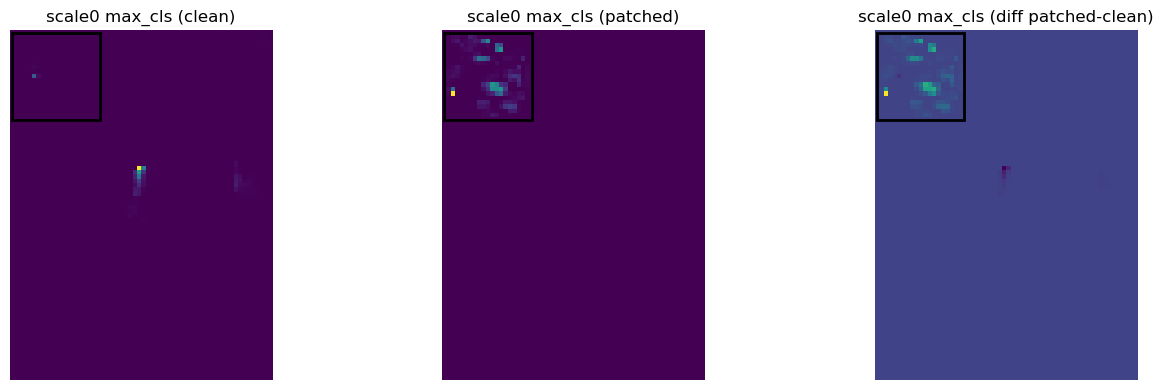

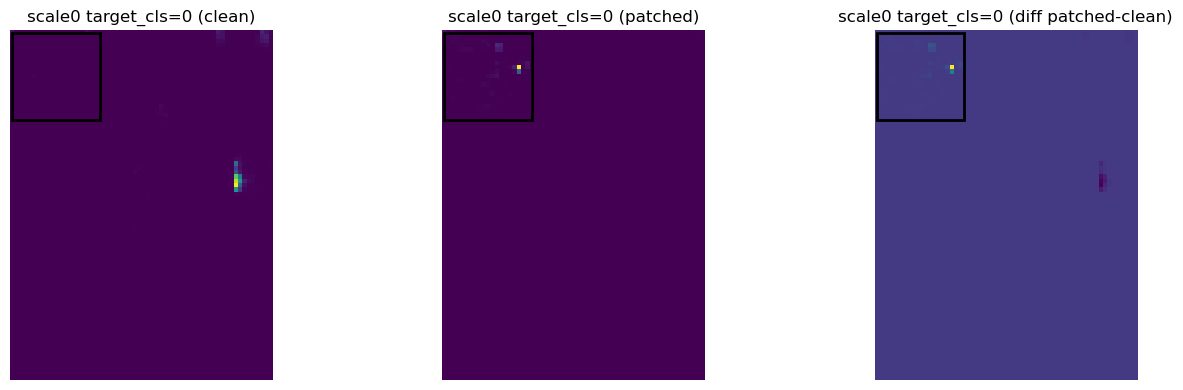

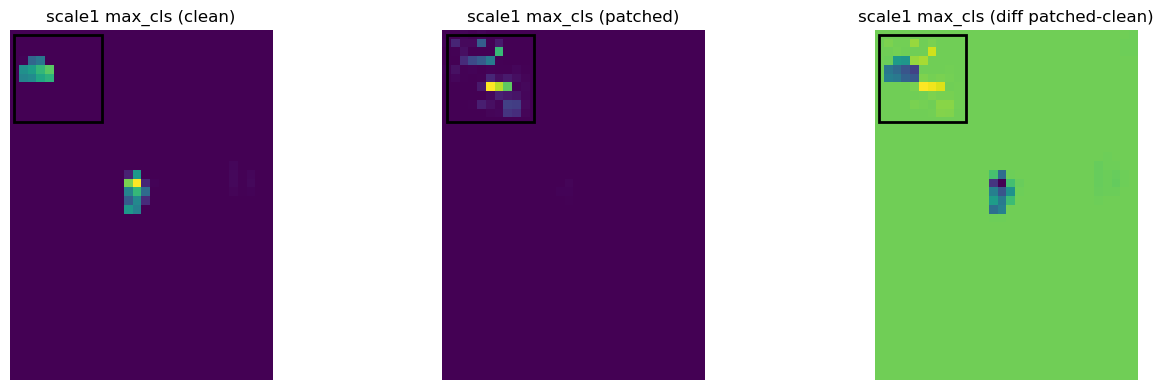

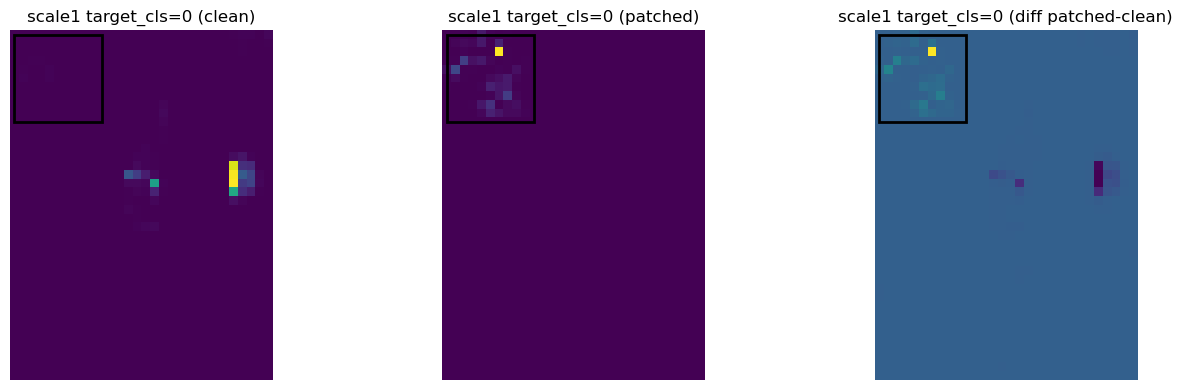

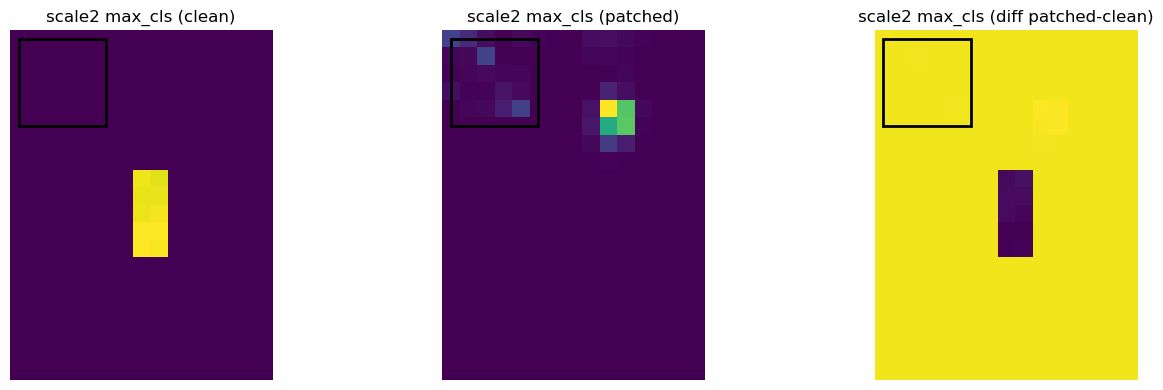

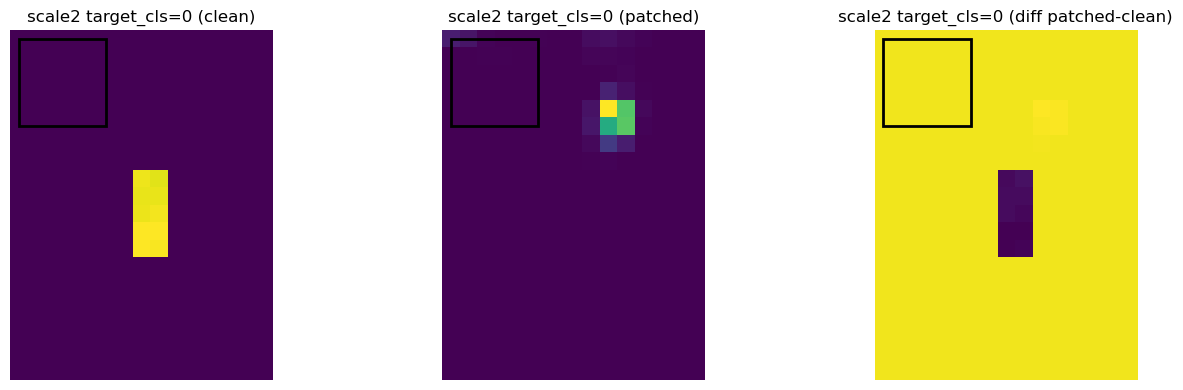

In [51]:
# -------------------------
# (C) Per-scale head heatmaps (clean vs patched vs diff)
# -------------------------
import numpy as np

def _reshape_map(x: torch.Tensor, H: int, W: int) -> np.ndarray:
    """x: (H*W,) -> (H,W) numpy."""
    return x.detach().cpu().reshape(H, W).numpy()

def _plot_triplet(a: np.ndarray, b: np.ndarray, title: str, patch_rect: Optional[Tuple[int,int,int,int]] = None):
    diff = b - a
    fig, axs = plt.subplots(1, 3, figsize=(14, 4))
    axs[0].imshow(a); axs[0].set_title(title + " (clean)"); axs[0].axis("off")
    axs[1].imshow(b); axs[1].set_title(title + " (patched)"); axs[1].axis("off")
    axs[2].imshow(diff); axs[2].set_title(title + " (diff patched-clean)"); axs[2].axis("off")
    if patch_rect is not None:
        fx1, fy1, fx2, fy2 = patch_rect
        for ax in axs:
            ax.add_patch(plt.Rectangle((fx1, fy1), fx2 - fx1, fy2 - fy1, fill=False, linewidth=2))
    plt.tight_layout()
    plt.show()

def _patch_rect_on_featmap(
    patch_bbox_xyxy_orig: List[float],
    orig_hw: Tuple[int, int],
    im_hw: Tuple[int, int],
    feat_hw: Tuple[int, int],
) -> Tuple[int,int,int,int]:
    pb = torch.tensor(patch_bbox_xyxy_orig, dtype=torch.float32)
    box_lb = _orig_to_letterbox_xyxy(pb, orig_hw, im_hw)
    Hf, Wf = feat_hw
    Hm, Wm = im_hw
    fx1, fy1, fx2, fy2 = _box_to_feature_coords(box_lb, Hf, Wf, Hm, Wm)
    return fx1, fy1, fx2, fy2

# Choose a target class for visualization: use baseline target#0 class if exists.
target_cls_for_map = baseline_targets[0].cls if baseline_targets else None
print(f"Visualizing heatmaps for target_cls={target_cls_for_map}")

pb = report["patch_info"]["patch_bbox_xyxy"]
for s_clean, s_patch in zip(clean_struct["per_scale"], patched_struct["per_scale"]):
    si = int(s_clean["scale_index"])
    Hf, Wf = int(s_clean["Hf"]), int(s_clean["Wf"])
    cls_clean = s_clean["cls"]  # (n,nc)
    cls_patch = s_patch["cls"]

    max_clean = cls_clean.max(dim=1).values if cls_clean.numel() else torch.zeros((Hf*Wf,))
    max_patch = cls_patch.max(dim=1).values if cls_patch.numel() else torch.zeros((Hf*Wf,))
    map_max_clean = _reshape_map(max_clean, Hf, Wf)
    map_max_patch = _reshape_map(max_patch, Hf, Wf)

    patch_rect = None
    if pb is not None:
        patch_rect = _patch_rect_on_featmap(pb, clean_struct["orig_hw"], clean_struct["im_hw"], (Hf, Wf))

    _plot_triplet(map_max_clean, map_max_patch, title=f"scale{si} max_cls", patch_rect=patch_rect)

    if target_cls_for_map is not None and cls_clean.numel():
        t_clean = cls_clean[:, int(target_cls_for_map)]
        t_patch = cls_patch[:, int(target_cls_for_map)]
        _plot_triplet(_reshape_map(t_clean, Hf, Wf), _reshape_map(t_patch, Hf, Wf), title=f"scale{si} target_cls={target_cls_for_map}", patch_rect=patch_rect)

## Запуск экспериментов


In [ ]:
# Запуск экспериментов для двух изображений

image_paths = [
    "data/person_012.png",
    "data/crop001602.png",
]
patch_path = "data/patch.png"

for image_path in image_paths:
    print("=" * 80)
    print(f"Running experiments for: {image_path}")
    print("=" * 80)
    experiment_baseline_diagnosis(image_path, patch_path)
    experiment_max_det_sensitivity(image_path, patch_path)
    experiment_conf_threshold_sweep(image_path, patch_path)
    experiment_nms_vs_no_nms(image_path, patch_path)
    experiment_lure_ablation(image_path, patch_path)
    experiment_feature_suppression_check(image_path, patch_path)
    experiment_baseline_target_listing(image_path, patch_path)
    experiment_baseline_target_max_det_sensitivity(image_path, patch_path)
    experiment_baseline_target_conf_sweep(image_path, patch_path)
    experiment_score_distribution_baseline(image_path, patch_path)
    experiment_score_distribution_sweep(image_path, patch_path)
